# Introduction to Gaussian process regression (Handout)

Course
- SURF 2016

Lecturer :
- Georgios Karagiannis, Department of Mathematics, Purdue

July 8, 2016

Objective :

- We wish to build a Gaussian Process regression --a probabilistic surrogate model-- in order to be able to emulate the output of the Piston Simulator, with respect to specified inputs.

Related material:

    Readings :
    
    - Rasmussen, Carl Edward. "Gaussian processes in machine learning." In Advanced lectures on machine learning, pp. 63-71. Springer Berlin Heidelberg, 2004. 	
        - see http://www.GaussianProcess.org/gpml
        - Chapters: 2, 4, 5.1, & 5.4.2

    - Slides provided
    
    Software :
    
    - R-cran (https://cran.r-project.org/)
    - R packages 
        - DiceKrigin (https://cran.r-project.org/web/packages/DiceKriging/index.html)
        - lhs (https://cran.r-project.org/web/packages/lhs/index.html)
    - Roustant, Olivier, David Ginsbourger, and Yves Deville. "DiceKriging, DiceOptim: Two R packages for the analysis of computer experiments by kriging-based metamodeling and optimization." (2012).
        - Plus dependences ...

## Software preparation

In [2]:
# DOWNLOAD THE R PACKAGES REQUIRED
install.packages('DiceKriging', repos = "http://cran.us.r-project.org")
install.packages('DiceOptim', repos = "http://cran.us.r-project.org")
install.packages('lhs', repos = "http://cran.us.r-project.org")
# install.packages('tcltk', repos = "http://cran.us.r-project.org")
# install.packages('aplpack', repos = "http://cran.us.r-project.org")

Installing package into ‘/export/users/gkaragia/R/x86_64-redhat-linux-gnu-library/3.3’
(as ‘lib’ is unspecified)
Warning message:
In install.packages("DiceKriging", repos = "http://cran.us.r-project.org"): installation of package ‘DiceKriging’ had non-zero exit statusInstalling package into ‘/export/users/gkaragia/R/x86_64-redhat-linux-gnu-library/3.3’
(as ‘lib’ is unspecified)
Installing package into ‘/export/users/gkaragia/R/x86_64-redhat-linux-gnu-library/3.3’
(as ‘lib’ is unspecified)
Warning message:
In install.packages("lhs", repos = "http://cran.us.r-project.org"): installation of package ‘lhs’ had non-zero exit status

In [3]:
# LOAD THE R PACKAGES REQUIRED
library('lhs')
library('DiceKriging')
library('DiceOptim')
# library('tcltk')
# library('aplpack')

Loading required package: rgenoud
##  rgenoud (Version 5.7-12.4, Build Date: 2015-07-19)
##  See http://sekhon.berkeley.edu/rgenoud for additional documentation.
##  Please cite software as:
##   Walter Mebane, Jr. and Jasjeet S. Sekhon. 2011.
##   ``Genetic Optimization Using Derivatives: The rgenoud package for R.''
##   Journal of Statistical Software, 42(11): 1-26. 
##

Loading required package: MASS
Loading required package: mnormt


## What is the function we pretend we do not know ?

We consider the Franke's 2D function, $f(x)$. 

We pretend that it is a "black-box" function; namely:
    - Its mathematical formula is not not available
    - It is too expensive to compute its output $f(x)$ for a given input $x$ 

However, just to satisfy our curiosity, here is how it looks like:

$$
f(x) =
  0.75  \exp(-\frac{(9 x_1-2)^2}{4} - \frac{(9 x_2-2)^2}{4})
+ 0.75  \exp(-\frac{(9 x_1+1)^2}{49} - \frac{(9 x_2+1)^2}{10}) \\
+ 0.5  \exp(-\frac{(9 x_1-7)^2}{4} - \frac{(9 x_2-3)^2}{4})
- 0.2  \exp(-(9x_1-4)^2 - (9x_2-7)^2)
$$



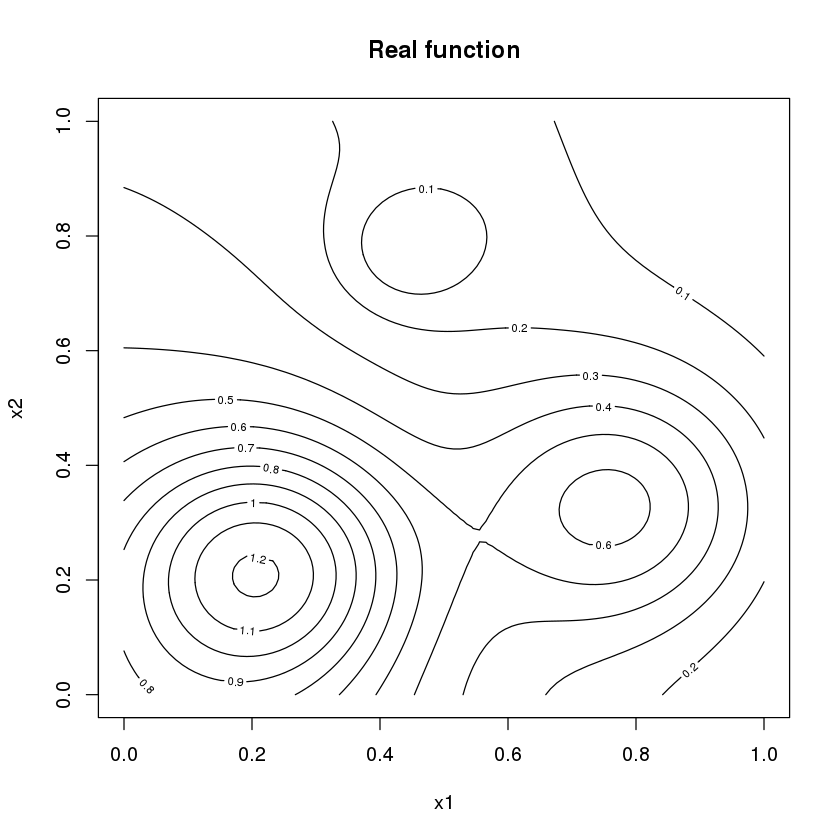

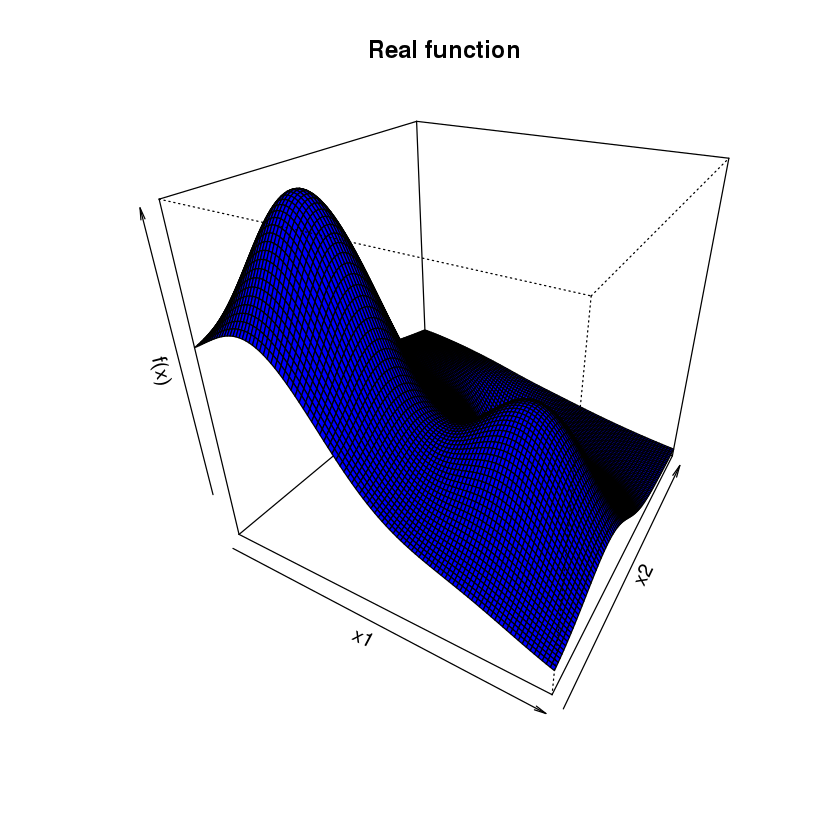

In [56]:
# THIS IS THE FUNCTION WE ARE INTERESTED IN

# Franke's 2D function
franke2d <- function(xx){ 
  x1 <- xx[1]
  x2 <- xx[2]
  term1 <- 0.75 * exp(-(9*x1-2)^2/4 - (9*x2-2)^2/4)
  term2 <- 0.75 * exp(-(9*x1+1)^2/49 - (9*x2+1)/10)
  term3 <- 0.5 * exp(-(9*x1-7)^2/4 - (9*x2-3)^2/4)
  term4 <- -0.2 * exp(-(9*x1-4)^2 - (9*x2-7)^2)
  y <- term1 + term2 + term3 + term4
  return(y)
}

myfun <- franke2d
input_min <- c(0.0  , 0.0)
input_max <- c(1.0  , 1.0)

n.grid <- 100 ;
x1.grid <-seq(input_min[1],input_max[1],length.out=n.grid) ;
x2.grid <-seq(input_min[2],input_max[2],length.out=n.grid) ;
X.grid <- expand.grid( x1=x1.grid,  x2=x2.grid )
y.grid <- apply(X.grid,1,myfun)

# Contour plot
contour(x1.grid, x2.grid, matrix(y.grid, n.grid, n.grid), 10, 
        main = "Real function", 
      xlab = "x1", ylab = "x2", 
       xlim = c(0,1), ylim = c(0,1))

# Surface plot
persp(x1.grid, x2.grid, matrix(y.grid, n.grid, n.grid ), 
      xlab = "x1", ylab = "x2", zlab = "f(x)",
      theta = 30, phi = 30,
      xlim = c(0,1), ylim = c(0,1),
      col='blue',
      main="Real function")

## Generate a training data-set

We consider there is available a training data-set $D={(x_i,y_i);i=1,...,n}$  of size $n=20$ that we have simulated via a LHS.

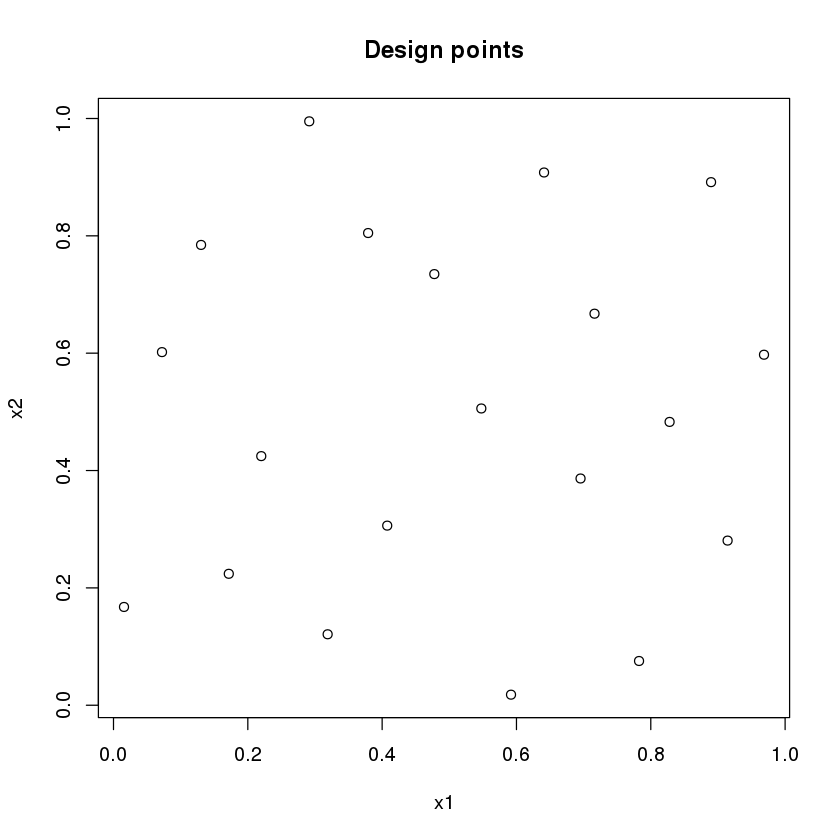

In [57]:
# Generate a training data-set 
n_data <- 20 ;
n_dim <- 2
X_data <- t(input_min + (input_max-input_min)*t(optimumLHS(n=n_data, k=n_dim))) ;
Y_data <- apply(X_data, 1, myfun) ;
plot(X_data, xlab = "x1", ylab = "x2", main="Design points")

# Have a look to the functions again

In [58]:
# We use the function:
#  km {DiceKriging}
?km

km                 package:DiceKriging                 R Documentation

_F_i_t _a_n_d/_o_r _c_r_e_a_t_e _k_r_i_g_i_n_g _m_o_d_e_l_s

_D_e_s_c_r_i_p_t_i_o_n:

     ‘km’ is used to fit kriging models when parameters are unknown, or
     to create ‘km’ objects otherwise. In both cases, the result is a
     ‘km’ object. If parameters are unknown, they are estimated by
     Maximum Likelihood. As a beta version, Penalized Maximum
     Likelihood Estimation is also possible if some penalty is given,
     or Leave-One-Out for noise-free observations.

_U_s_a_g_e:

     km(formula=~1, design, response, covtype="matern5_2",
        coef.trend = NULL, coef.cov = NULL, coef.var = NULL,
        nugget = NULL, nugget.estim=FALSE, noise.var=NULL, estim.method="MLE",
        penalty = NULL, optim.method = "BFGS", lower = NULL, upper = NULL, 
        parinit = NULL, multistart = 1, control = NULL, gr = TRUE, 
        iso=FALSE, scaling=FALSE, knots=NULL, kernel=NULL)
     
_A_r_g_u_m_e_n_t_s:

 formula: an optional object of class "formula" specifying the linear
          trend of the kriging model (see ‘lm’). This formula should
          concern only the input variables, and not the output
          (response). If there is any, it is automatically dropped. In
          particular, no response transformation is available yet. The
          default is ‘~1’, which defines a constant trend.

  design: a data frame representing the design of experiments. The ith
          row contains the values of the d input variables
          corresponding to the ith evaluation

response: a vector (or 1-column matrix or data frame) containing the
          values of the 1-dimensional output given by the objective
          function at the ‘design’ points.

 covtype: an optional character string specifying the covariance
          structure to be used, to be chosen between ‘"gauss"’,
          ‘"matern5_2"’, ‘"matern3_2"’, ‘"exp"’ or ‘"powexp"’. See a
          full description of available covariance kernels in
          ‘covTensorProduct-class’. Default is ‘"matern5_2"’. See also
          the argument ‘kernel’ that allows the user to build its own
          covariance structure.

coef.trend,: (see below)

coef.cov,: (see below)

coef.var: optional vectors containing the values for the trend,
          covariance and variance parameters. For estimation, 4 cases
          are implemented: 1. (All unknown) If all are missing, all are
          estimated. 2. (All known) If all are provided, no estimation
          is performed; 3. (Known trend) If ‘coef.trend’ is provided
          but at least one of ‘coef.cov’ or ‘coef.var’ is missing, then
          BOTH ‘coef.cov’ and ‘coef.var’ are estimated; 4. (Unknown
          trend) If ‘coef.cov’ and ‘coef.var’ are provided but
          ‘coef.trend’ is missing, then ‘coef.trend’ is estimated (GLS
          formula).

  nugget: an optional variance value standing for the homogeneous
          nugget effect.

nugget.estim: an optional boolean indicating whether the nugget effect
          should be estimated. Note that this option does not concern
          the case of heterogeneous noisy observations (see ‘noise.var’
          below). If ‘nugget’ is given, it is used as an initial value.
          Default is ‘FALSE’.

noise.var: for noisy observations : an optional vector containing the
          noise variance at each observation. This is useful for
          stochastic simulators. Default is ‘NULL’.

estim.method: a character string specifying the method by which unknown
          parameters are estimated. Default is ‘"MLE"’ (Maximum
          Likelihood). At this stage, a beta version of leave-One-Out
          estimation (‘estim.method="LOO"’) is also implemented for
          noise-free observations.

 penalty: (beta version) an optional list suitable for Penalized
          Maximum Likelihood Estimation. The list must contain the item
          ‘fun’ indicatin

## Compare different GP regression models

Use the diagnostics we leant, and compare Gaussian process regression models deffering on the prior linear trend structure or the covariance function

In [59]:
# Diagnostics (Feel free to use others that you know)

R2 <-function (Y, Ypred) {
    Ypred <- as.numeric(Ypred)
    Y <- as.numeric(Y)
    return(1 - mean((Y - Ypred)^2)/mean((Y - mean(Y))^2))
}

RMSE <- function (Y, Ypred)  {
    Ypred <- as.numeric(Ypred)
    Y <- as.numeric(Y)
    return(sqrt(mean((Y - Ypred)^2)))
}

MAE <- function (Y, Ypred)  {
    Ypred <- as.numeric(Ypred) 
    Y <- as.numeric(Y)
    return(mean(abs(Y - Ypred)))
}

In [60]:
# Train different GP regressions differing on the covariance function

myfun_km_matern5_2 <- km( formula = ~ 1 , # linear trend formula; E.G.: "formula = ~ 1 +x1 +exp(x2) +I(x1*x2) +I(x1^2)"
                design = data.frame(x1=X_data[,1], 
                                    x2=X_data[,2]), # a data frame representing the design of experiments.
                response=Y_data,                    # the values of the 1-dimensional outpu 
                covtype="matern5_2",                # covariance structure 
                coef.trend = NULL,                  # values for the trend parameters
                coef.cov = NULL,                    # values for the covariance parameters
                coef.var = NULL,                    # values for the variance parameters
                nugget= 1e-7,                       # the homogeneous nugget effect
                noise.var = NULL,                   # containing the noise variance at each observation
                optim.method = "BFGS",              # optimization method is chosen for the likelihood maximization.
                lower = NULL,                       # lower bounds of the correlation parameters for optimization
                upper = NULL,                       # upper bounds of the correlation parameters for optimizati
                control =list(trace=FALSE),         # =list(trace=FALSE) to supress optimization trace information
                kernel=NULL)                        # a user's new covariance structure

myfun_km_matern3_2  <- km( formula = ~ 1 , # linear trend formula; E.G.: "formula = ~ 1 +x1 +exp(x2) +I(x1*x2) +I(x1^2)"
                design = data.frame(x1=X_data[,1], 
                                    x2=X_data[,2]), # a data frame representing the design of experiments.
                response=Y_data,                    # the values of the 1-dimensional outpu 
                covtype="matern3_2",                # covariance structure 
                coef.trend = NULL,                  # values for the trend parameters
                coef.cov = NULL,                    # values for the covariance parameters
                coef.var = NULL,                    # values for the variance parameters
                nugget= 1e-7,                       # the homogeneous nugget effect
                noise.var = NULL,                   # containing the noise variance at each observation
                optim.method = "BFGS",              # optimization method is chosen for the likelihood maximization.
                lower = NULL,                       # lower bounds of the correlation parameters for optimization
                upper = NULL,                       # upper bounds of the correlation parameters for optimizati
                control =list(trace=FALSE),         # =list(trace=FALSE) to supress optimization trace information
                kernel=NULL)  

myfun_km_gauss <- km( formula = ~ 1 ,        # linear trend formula; E.G.: "formula = ~ 1 +x1 +exp(x2) +I(x1*x2) +I(x1^2)"
                design = data.frame(x1=X_data[,1], 
                                    x2=X_data[,2]), # a data frame representing the design of experiments.
                response=Y_data,                    # the values of the 1-dimensional outpu 
                covtype="gauss",                    # covariance structure 
                coef.trend = NULL,                  # values for the trend parameters
                coef.cov = NULL,                    # values for the covariance parameters
                coef.var = NULL,                    # values for the variance parameters
                nugget= 1e-7,                       # the homogeneous nugget effect
                noise.var = NULL,                   # containing the noise variance at each observation
                optim.method = "BFGS",              # optimization method is chosen for the likelihood maximization.
                lower = NULL,                       # lower bounds of the correlation parameters for optimization
                upper = NULL,                       # upper bounds of the correlation parameters for optimizati
                control =list(trace=FALSE),         # =list(trace=FALSE) to supress optimization trace information
                kernel=NULL)                        # a user's new covariance structure

myfun_km_exp <- km( formula = ~ 1 , # linear trend formula; E.G.: "formula = ~ 1 +x1 +exp(x2) +I(x1*x2) +I(x1^2)"
                design = data.frame(x1=X_data[,1], 
                                    x2=X_data[,2]), # a data frame representing the design of experiments.
                response=Y_data,                    # the values of the 1-dimensional outpu 
                covtype="exp",                      # covariance structure 
                coef.trend = NULL,                  # values for the trend parameters
                coef.cov = NULL,                    # values for the covariance parameters
                coef.var = NULL,                    # values for the variance parameters
                nugget= 1e-7,                       # the homogeneous nugget effect
                noise.var = NULL,                   # containing the noise variance at each observation
                optim.method = "BFGS",              # optimization method is chosen for the likelihood maximization.
                lower = NULL,                       # lower bounds of the correlation parameters for optimization
                upper = NULL,                       # upper bounds of the correlation parameters for optimizati
                control =list(trace=FALSE),         # =list(trace=FALSE) to supress optimization trace information
                kernel=NULL)                        # a user's new covariance structure

# CROSS VALIDATION CRITERIA
Y_pred <- leaveOneOut.km(myfun_km_matern5_2, "UK")$mean
CV_matern5_2 <-data.frame( R2 = R2(Y_data, Y_pred),
                            RMSE = RMSE(Y_data, Y_pred),
                            MAE = MAE(Y_data, Y_pred), row.names="matern5_2")


Y_pred <- leaveOneOut.km(myfun_km_matern3_2, "UK")$mean
CV_matern3_2 <-data.frame( R2 = R2(Y_data, Y_pred),
                            RMSE = RMSE(Y_data, Y_pred),
                            MAE = MAE(Y_data, Y_pred), row.names="matern3_2")

Y_pred <- leaveOneOut.km(myfun_km_gauss, "UK")$mean
CV_gauss <-data.frame( R2 = R2(Y_data, Y_pred),
                            RMSE = RMSE(Y_data, Y_pred),
                            MAE = MAE(Y_data, Y_pred), row.names="gauss~~~~")

Y_pred <- leaveOneOut.km(myfun_km_exp, "UK")$mean
CV_exp <-data.frame( R2 = R2(Y_data, Y_pred),
                            RMSE = RMSE(Y_data, Y_pred),
                            MAE = MAE(Y_data, Y_pred), row.names="exp~~~~~~")


CV_matern5_2
CV_matern3_2
CV_gauss
CV_exp

R2       RMSE        MAE
matern5_2 0.9307111 0.08303815 0.05454321

R2       RMSE        MAE
matern3_2 0.9131285 0.09297892 0.06339989

R2       RMSE        MAE
gauss~~~~ 0.9447451 0.07415343 0.05328847

R2      RMSE        MAE
exp~~~~~~ 0.8444404 0.1244212 0.09736665

## Choose the 'Best' model

In [61]:
# Train the GP regression

myfun_km <- myfun_km_matern5_2

## Check the validity of the chossen 'Best' model

R2       RMSE        MAE
1 0.9307111 0.08303815 0.05454321

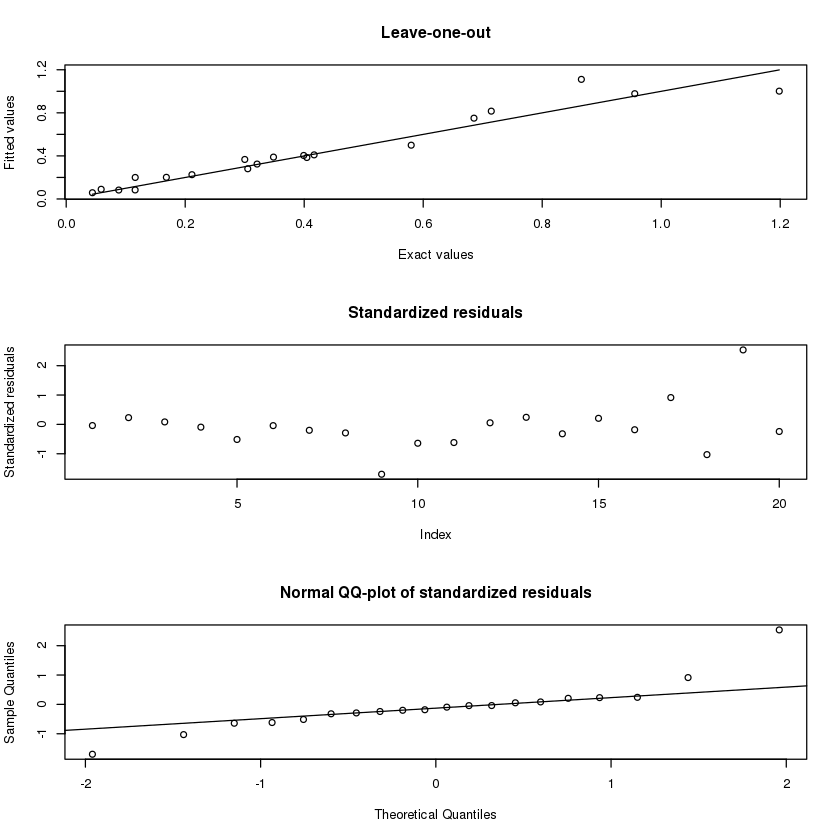

In [62]:
# CROSS VALIDATION CRITERIA
Y_pred <- leaveOneOut.km(myfun_km, "UK")$mean
data.frame(
    R2 = R2(Y_data, Y_pred),
    RMSE = RMSE(Y_data, Y_pred),
    MAE = MAE(Y_data, Y_pred))

# PLOT DIAGNOSTICS
plot(myfun_km)

## Print the estimates of the hyperparameters

In [63]:
# PRINT THE PARAMETERS

show(myfun_km)


Call:
km(formula = ~1, design = data.frame(x1 = X_data[, 1], x2 = X_data[, 
    2]), response = Y_data, covtype = "matern5_2", coef.trend = NULL, 
    coef.cov = NULL, coef.var = NULL, nugget = 1e-07, noise.var = NULL, 
    optim.method = "BFGS", lower = NULL, upper = NULL, control = list(trace = FALSE), 
    kernel = NULL)

Trend  coeff.:
               Estimate
 (Intercept)     0.3175

Covar. type  : matern5_2 
Covar. coeff.:
               Estimate
   theta(x1)     0.3166
   theta(x2)     0.3527

Variance estimate: 0.08896155

Nugget effect : 1e-07



## Plot the Posterior GP mean and variance for predictions

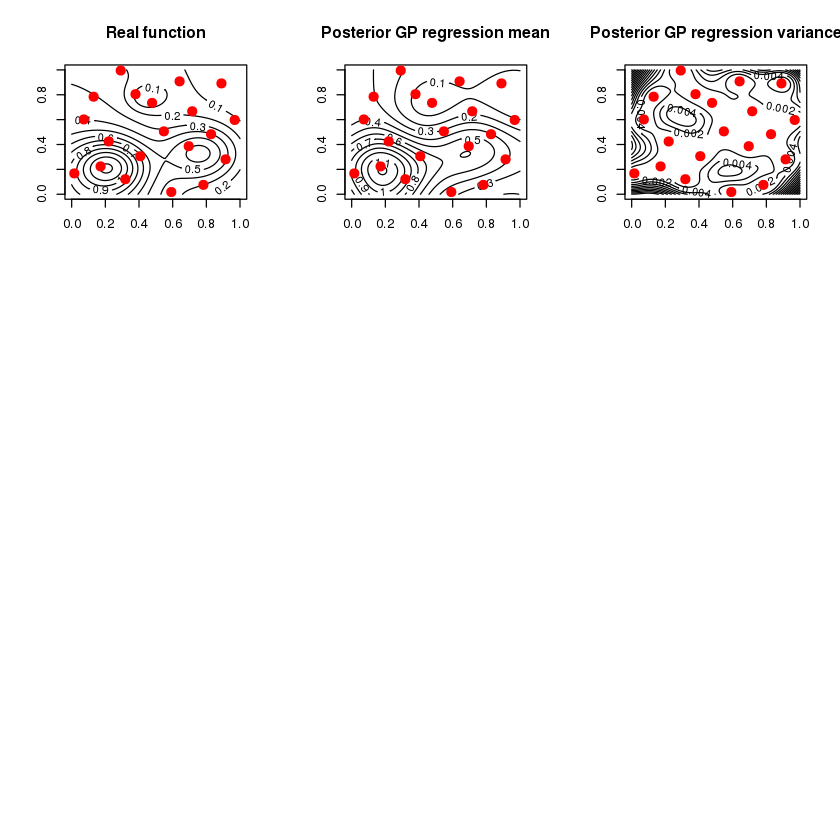

In [64]:
# Plot the 
n.grid <- 100 ;
x1.grid <-seq(input_min[1],input_max[1],length.out=n.grid) ;
x2.grid <-seq(input_min[2],input_max[2],length.out=n.grid) ;
X.grid <- expand.grid( x1=x1.grid,  x2=x2.grid )
y.grid <- apply(X.grid, 1, myfun)
y.pred.grid <- predict(myfun_km, X.grid, "UK")
par(mfrow = c(3,3))
    contour(x1.grid, x2.grid, matrix(y.grid, n.grid, n.grid), 11, main = "Real function")
    points(X_data[ , 1], X_data[ , 2], pch = 19, cex = 1.5, col = "red")
    contour(x1.grid, x2.grid, matrix(y.pred.grid$mean, n.grid, n.grid), 11, main = "Posterior GP regression mean")
    points(X_data[ , 1], X_data[ , 2], pch = 19, cex = 1.5, col = "red")
    contour(x1.grid, x2.grid, matrix(y.pred.grid$sd^2, n.grid, n.grid), 15, main = "Posterior GP regression variance")
    points(X_data[ , 1], X_data[ , 2], pch = 19, cex = 1.5, col = "red")


# Other Benchmark functions

In [ ]:
# Franke's 2D function
franke2d <- function(xx){ 
  x1 <- xx[1]
  x2 <- xx[2]
  term1 <- 0.75 * exp(-(9*x1-2)^2/4 - (9*x2-2)^2/4)
  term2 <- 0.75 * exp(-(9*x1+1)^2/49 - (9*x2+1)/10)
  term3 <- 0.5 * exp(-(9*x1-7)^2/4 - (9*x2-3)^2/4)
  term4 <- -0.2 * exp(-(9*x1-4)^2 - (9*x2-7)^2)
  y <- term1 + term2 + term3 + term4
  return(y)
}
input_min <- c(0.0  , 0.0)
input_max <- c(1.0  , 1.0)

# Branin's (rescaled) 2D function
braninsc <- function(xx) {
  x1 <- xx[1]
  x2 <- xx[2]
  x1bar <- 15*x1 - 5
  x2bar <- 15 * x2
  term1 <- x2bar - 5.1*x1bar^2/(4*pi^2) + 5*x1bar/pi - 6
  term2 <- (10 - 10/(8*pi)) * cos(x1bar)
  y <- (term1^2 + term2 - 44.81) / 51.95
  return(y)
}
input_min <- c(0.0  , 0.0)
input_max <- c(1.0  , 1.0)

# Curretal's 2D function
curretal2d <- function(xx) {
  x1 <- xx[1]
  x2 <- xx[2]
  fact1 <- 1 - exp(-1/(2*x2))
  fact2 <- 2300*x1^3 + 1900*x1^2 + 2092*x1 + 60
  fact3 <- 100*x1^3 + 500*x1^2 + 4*x1 + 20
  y <- fact1 * fact2/fact3
  return(y)
}
input_min <- c(0.0  , 0.0)

input_max <- c(1.0  , 1.0)